In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('../data/proceed/Clean_data.csv')
data.head()

C:\Users\Warin\AppData\Local\Temp\ipykernel_20944\3359318555.py:1: DtypeWarning: Columns (2,4,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/proceed/Clean_data.csv')


,accounting_date,company_code,customer_code,customer_district_code,item_code,business_chain_l1_name,salesperson_code,market_segment,value_sales,value_cost,...,business_chain_l1_code_ZZ1,business_chain_l1_code_ZZ2,contact_method_code_Other,order_type_code_NOR,order_type_code_Other,Profit,Unit_Price,Profit_Margin,Transformed_Profit,Transformed_Unit_Price
0,2012-05-09,101,411800601,410,GENIE8WWWBC,ElectraCorp Ltd,T612,Commercial & Industrial,218.40,178.1976,...,False,False,False,True,False,40.2024,2.60,18.407692,6.340536,1.280934
1,2012-02-16,101,361000403,300,GENIE8WWWBC,BrightPower Solutions,P345,Commercial & Industrial,38.28,25.4568,...,False,False,False,True,False,12.8232,3.19,33.498433,3.580950,1.432701
2,2012-05-09,101,361000403,300,GENIE8WWWBC,BrightPower Solutions,P345,Commercial & Industrial,40.20,25.4568,...,False,False,False,True,False,14.7432,3.35,36.674627,3.839687,1.470176
3,2012-05-18,101,565540415,500,GENIE8WWWBC,Global Electric Wholesalers,T504,Commercial & Industrial,20.10,12.7284,...,False,False,False,False,False,7.3716,3.35,36.674627,2.715069,1.470176
4,2012-01-09,101,565540415,500,GENIE8WWWBC,Global Electric Wholesalers,T504,Commercial & Industrial,19.14,12.7284,...,False,False,False,False,False,6.4116,3.19,33.498433,2.532114,1.432701


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971500 entries, 0 to 1971499
Data columns (total 85 columns):
 #   Column                                  Dtype  
---  ------                                  -----  
 0   accounting_date                         object 
 1   company_code                            int64  
 2   customer_code                           object 
 3   customer_district_code                  int64  
 4   item_code                               object 
 5   business_chain_l1_name                  object 
 6   salesperson_code                        object 
 7   market_segment                          object 
 8   value_sales                             float64
 9   value_cost                              float64
 10  value_quantity                          float64
 11  value_price_adjustment                  int64  
 12  currency                                object 
 13  invoice_number                          int64  
 14  line_number                       

<Axes: xlabel='value_sales', ylabel='Count'>

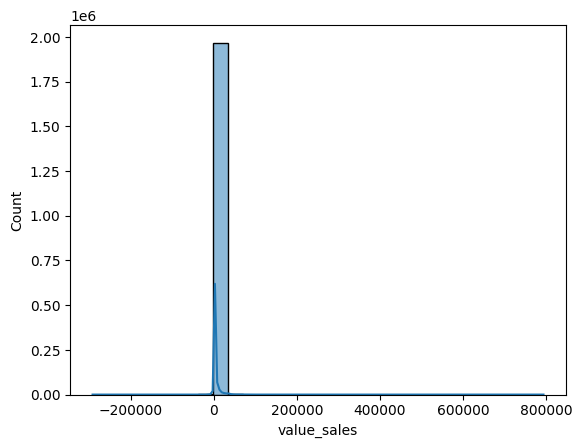

In [5]:
sns.histplot(data=data, x='value_sales', bins=30, kde=True)

In [11]:
#create daily sale
filtered_data = data[['order_date', 'value_sales']]
#change order_date to datetime
filtered_data['order_date'] = pd.to_datetime(filtered_data['order_date'])
#posive value sales
filtered_data = filtered_data[filtered_data['value_sales'] > 0]
#create daily sale
daily_sale = filtered_data.groupby('order_date')['value_sales'].sum().reset_index()
#filter date between 2012 and 2013
daily_sale = daily_sale[(daily_sale['order_date'] >= '2012-01-01') & (daily_sale['order_date'] <= '2013-12-31')]
#interpolate missing date
daily_sale = daily_sale.set_index('order_date').resample('D').sum().reset_index()
#fill missing value
daily_sale['value_sales'] = daily_sale['value_sales'].fillna(0)
daily_sale

C:\Users\Warin\AppData\Local\Temp\ipykernel_20944\2773801879.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['order_date'] = pd.to_datetime(filtered_data['order_date'])


,order_date,value_sales
0,2012-01-01,325.2000
1,2012-01-02,44819.3620
2,2012-01-03,659479.3300
3,2012-01-04,608059.4060
4,2012-01-05,342315.6920
...,...,...
725,2013-12-26,278.6000
726,2013-12-27,8976.7500
727,2013-12-28,0.0000
728,2013-12-29,0.0000


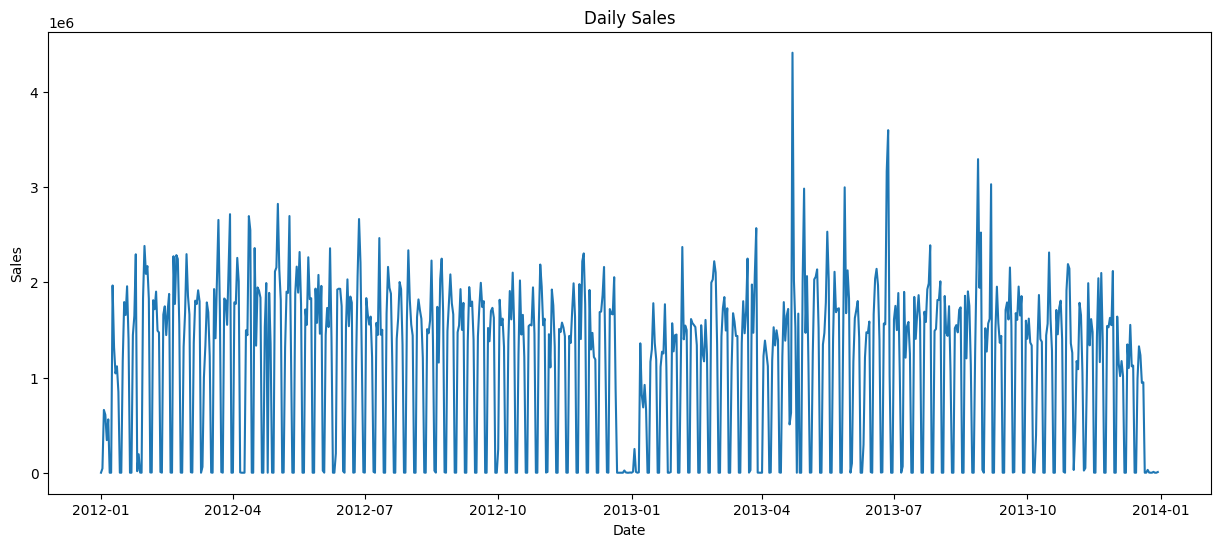

In [12]:
#plot daily sale
plt.figure(figsize=(15, 6))
plt.plot(daily_sale['order_date'], daily_sale['value_sales'])
plt.title('Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()


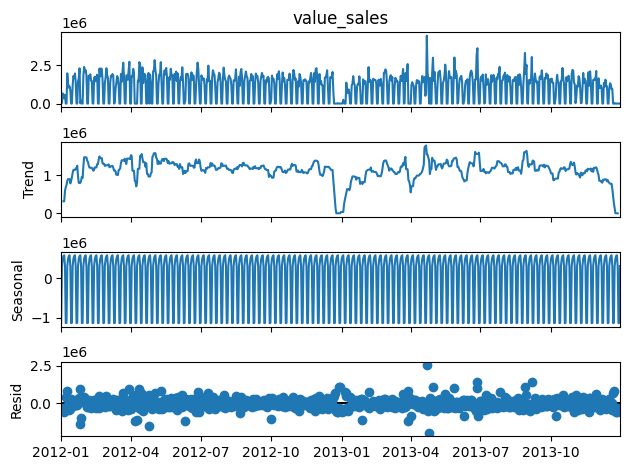

In [13]:
#decompose time series
from statsmodels.tsa.seasonal import seasonal_decompose
daily_sale = daily_sale.set_index('order_date')
result = seasonal_decompose(daily_sale['value_sales'], model='additive')
result.plot()
plt.show()

c:\Users\Warin\anaconda3\envs\BUSA8000\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Warin\anaconda3\envs\BUSA8000\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


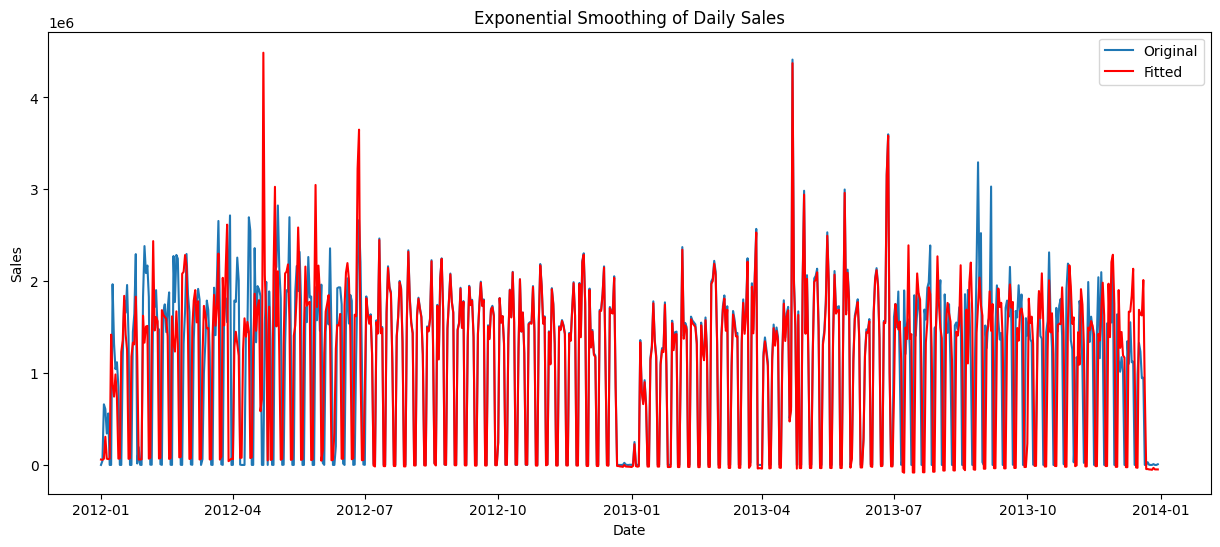

In [14]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Apply exponential smoothing
model = ExponentialSmoothing(daily_sale['value_sales'], trend='add', seasonal='add', seasonal_periods=365)
fit = model.fit()

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(daily_sale.index, daily_sale['value_sales'], label='Original')
plt.plot(daily_sale.index, fit.fittedvalues, label='Fitted', color='red')
plt.title('Exponential Smoothing of Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [27]:
# evaluate model
from sklearn.metrics import mean_squared_error
from math import sqrt

# Make predictions
predictions = fit.fittedvalues
#replace negative value with 0
predictions[predictions < 0] = 0

# Calculate RMSE
rmse = sqrt(mean_squared_error(daily_sale['value_sales'], predictions))
print(rmse)

#R2 score
from sklearn.metrics import r2_score
r2 = r2_score(daily_sale['value_sales'], predictions)
print(f"R2 score = {r2}")


644488.061089216
R2 score = 0.42404381635595556


In [18]:
# Forecast the future
forecast = fit.forecast(steps=365)
forecast = pd.DataFrame(forecast, columns=['value_sales'])
forecast['order_date'] = pd.date_range(start='2014-01-01', periods=365)
forecast = forecast.set_index('order_date')
# replace negative value with 0
forecast['value_sales'] = forecast['value_sales'].apply(lambda x: 0 if x < 0 else x)
forecast

,value_sales
order_date,
2014-01-01,0.000000
2014-01-02,0.000000
2014-01-03,0.000000
2014-01-04,195637.230739
2014-01-05,0.000000
...,...
2014-12-27,0.000000
2014-12-28,0.000000
2014-12-29,0.000000


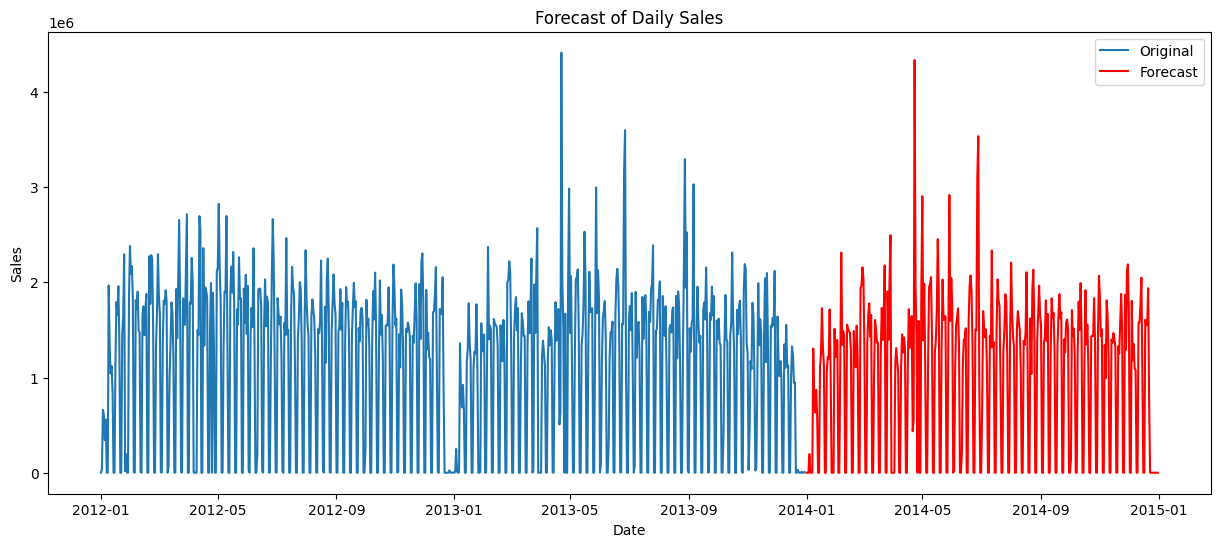

In [19]:
# Plot the forecast
plt.figure(figsize=(15, 6))
plt.plot(daily_sale.index, daily_sale['value_sales'], label='Original')
plt.plot(forecast.index, forecast['value_sales'], label='Forecast', color='red')
plt.title('Forecast of Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()
